In [94]:
# time series dataset of airline passenger travel from https://www.kaggle.com/andreazzini/international-airline-passengers

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels 
import matplotlib.pyplot as plt
from pylab import rcParams

# setting a default figure size for timeseries plots

rcParams['figure.figsize'] = 12,4

# inspecting the data

df = pd.read_csv('international-airline-passengers.csv')

df

# tidying up the data

df.drop(index = 144, inplace = True)
df.rename(columns = {'Month': 'Date','International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60': 
                     'passengers_thousands'}, inplace= True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df = df.dropna()

# setting the sampling frequency to months
df.index.freq = 'MS'

df.head()

,passengers_thousands
Date,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


Text(0, 0.5, 'Airline Passengers (1000s)')

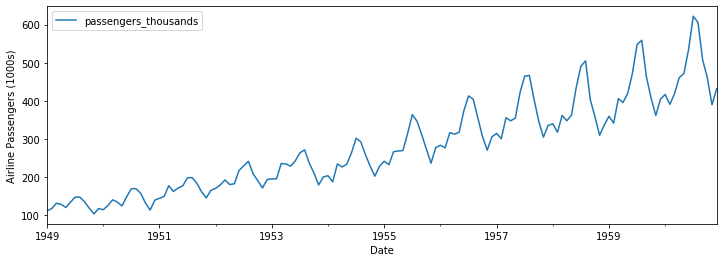

In [95]:
# plotting the timeseries

df.plot(figsize = (12,4)).set_ylabel('Airline Passengers (1000s)')

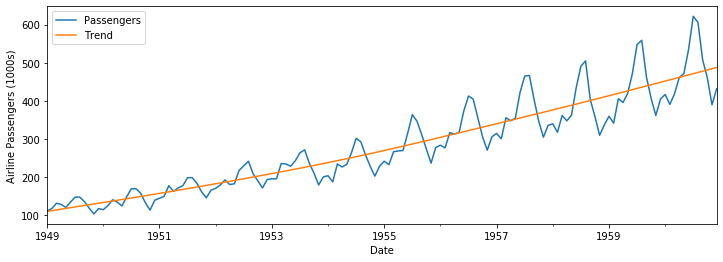

In [96]:
# using statsmodels Hodrick-Prescott filter to decompose the time series into cycle and trend components

hp = sm.tsa.filters.hpfilter

cycle, trend = hp(df, lamb = 129600)
df['cycle'] = cycle
df['trend'] = trend

# plotting the trend against the original time series

df['passengers_thousands'].plot(figsize = (12,4), label = 'Passengers')
df['trend'].plot(label = 'Trend').set_ylabel('Airline Passengers (1000s)')
plt.legend()

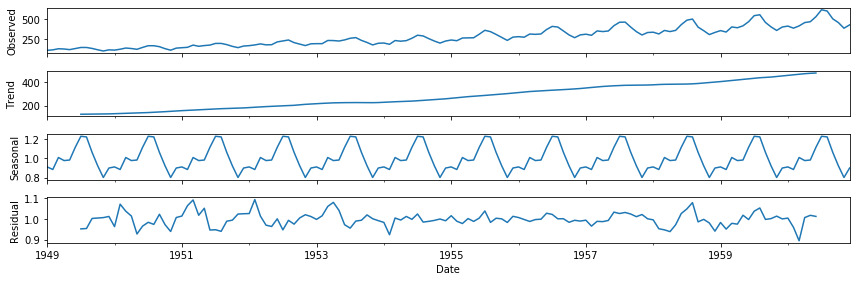

In [97]:
# using statsmodels seasonal decomposition to plot the trend and seasonal components

seasonal = sm.tsa.seasonal_decompose

df2 =  seasonal(df['passengers_thousands'], model = 'multiplicative')

df2.plot();

The model was trained on 75% of the dataset: 36 months of the time series was excluded from the training set.


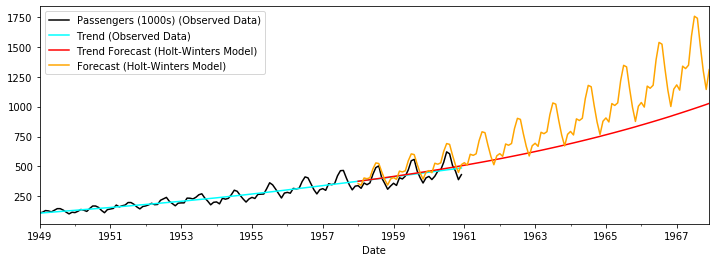

In [98]:
# using the observed time series and the trend component to train multiplicative Holt-Winters models. The models are then
# used to predict the trend and the 'trend+seasonal' data for 12 years after the observed time series ends.

print('The model was trained on 75% of the dataset:', round(len(df.index)*0.25), 'months of the time series was excluded from the training set.')

# training the model on 75% of the trend data

train_sample_trend = df['trend'].iloc[:-36]

hw_trend_mod = statsmodels.tsa.holtwinters.ExponentialSmoothing(train_sample_trend, trend = 'mul',
                                                         seasonal = 'mul')
hw_trend_mod = hw_trend_mod.fit(optimized = True)

trend_prediction = hw_trend_mod.forecast(120)

# training a model on 75% of the observed data

train_sample= df['passengers_thousands'].iloc[:-36]

hw_mod = statsmodels.tsa.holtwinters.ExponentialSmoothing(train_sample, trend = 'mul',
                                                         seasonal = 'mul')
hw_mod = hw_mod.fit(optimized = True)

prediction = hw_mod.forecast(120)

# plotting the observed data and observed trend against the forecasts

df['passengers_thousands'].plot(label = 'Passengers (1000s) (Observed Data)', legend = True, color ='black')
df['trend'].plot(label = 'Trend (Observed Data)', legend = True, color = 'cyan')
trend_prediction.plot(color = 'red', label = 'Trend Forecast (Holt-Winters Model)', legend = True)
prediction.plot(label = 'Forecast (Holt-Winters Model)', color = 'orange', legend = True)


Mean Absolute Error of the Forecast (Passengers, 1000s)= 53.16166665051881

Mean Absolute Error Value calculated by Sklearn: 53.16166665051881

Root Mean Squared Error of the Forecast (Passengers, 1000s)= 56.571564587522474

Root Mean Squared Error Value calculated by Sklearn: 56.571564587522474


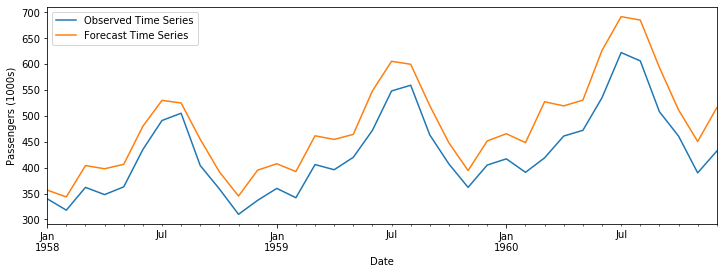

In [99]:
# calculating mean absolute error for the forcast

out_sample = df['passengers_thousands'].iloc[-36:]

prediction_outsample = prediction.loc['1958-01-01':'1960-12-01']

count = 0
mae = []

for i in out_sample:
    mae.append(abs(i - prediction_outsample[count]))
    count = count+1
    
mae = sum(mae)/len(out_sample)

out_sample.plot(label = 'Observed Time Series' , legend = True)
prediction_outsample.plot(label = 'Forecast Time Series', legend = True).set_ylabel('Passengers (1000s)')

print('Mean Absolute Error of the Forecast (Passengers, 1000s)=', mae)
print()

# checking my calculation using sklearn function for mean absolute error
from sklearn.metrics import mean_absolute_error
y = out_sample
y_hat = prediction_outsample
maesk = mean_absolute_error(y, y_hat)
print('Mean Absolute Error Value calculated by Sklearn:', maesk)
print()

# calculating the root mean squared error of the forecast

import math

count = 0
rmse = []

for i in out_sample:
    rmse.append((i - prediction_outsample[count])**2)
    count = count+1
    
rmse = math.sqrt(sum(rmse)/len(out_sample))

print('Root Mean Squared Error of the Forecast (Passengers, 1000s)=', rmse)
print()

# checking my calculation using sklearn function for root mean squared error

from sklearn.metrics import mean_squared_error
y = out_sample
y_hat = prediction_outsample
rmsesk = math.sqrt(mean_squared_error(y, y_hat))
print('Root Mean Squared Error Value calculated by Sklearn:', rmsesk)


Mean Absolute Error of the Trend Forecast (Passengers, 1000s)= 6.745760401093402

Mean Absolute Error Value calculated by Sklearn: 6.745760401093402

Root Mean Squared Error of the Trend Forecast (Passengers, 1000s)= 8.599444140234157

Root Mean Squared Error  Value calculated by Sklearn: 8.599444140234157


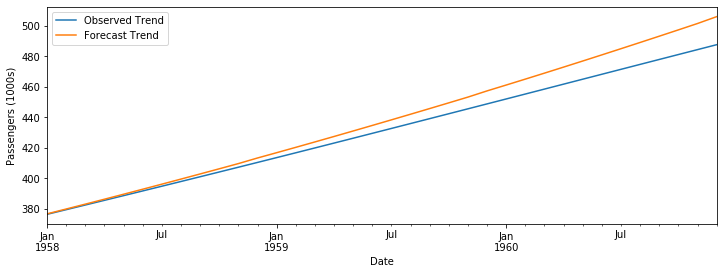

In [100]:
# calculating mean absolute error for the trend forcast

out_sample_trend = df['trend'].iloc[-36:]

trend_prediction_outsample = trend_prediction.loc['1958-01-01':'1960-12-01']

count=0
mae_trend =  []

for i in out_sample_trend:
    mae_trend.append(abs(i - trend_prediction_outsample[count]))
    count = count + 1

mae_trend = sum(mae_trend)/len(out_sample_trend)
    

out_sample_trend.plot(label = 'Observed Trend', legend = True)
trend_prediction_outsample.plot(label = 'Forecast Trend', legend = True).set_ylabel('Passengers (1000s)')

print('Mean Absolute Error of the Trend Forecast (Passengers, 1000s)=', mae_trend)
print()

# checking my calculation using sklearn function for mean absolute error

y = out_sample_trend
y_hat = trend_prediction_outsample
maesk2 = mean_absolute_error(y, y_hat)
print('Mean Absolute Error Value calculated by Sklearn:', maesk2)
print()

# calculating the root mean squared error of the trend forecast

import math

count = 0
rmse_trend = []

for i in out_sample_trend:
    rmse_trend.append((i - trend_prediction_outsample[count])**2)
    count = count+1
    
rmse_trend = math.sqrt(sum(rmse_trend)/len(out_sample))

print('Root Mean Squared Error of the Trend Forecast (Passengers, 1000s)=', rmse_trend)
print()

# checking my calculation using sklearn function for root mean squared error

from sklearn.metrics import mean_squared_error
y = out_sample_trend
y_hat = trend_prediction_outsample
rmsesk2 = math.sqrt(mean_squared_error(y, y_hat))
print('Root Mean Squared Error  Value calculated by Sklearn:', rmsesk2)